In [22]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import jax
device = jax.default_backend()
device_amount = jax.local_device_count()
print(device, device_amount)

gpu 1


In [23]:
df = pd.read_csv('../data/player_stats_trends.csv')
tournament_stats = pd.read_csv('../data/tournament_stats.csv')
goals = pd.read_csv('../data/goals.csv')
awards = pd.read_csv('../data/awards.csv')

In [24]:
awards['Year'] = awards['Season'].apply(lambda x: float(str(x)[-2:]))
awards = awards.drop(columns=['Season', 'Club/Country'])
awards = awards.groupby('Award').filter(lambda x: len(x) >= 5)
awards = awards[~awards['Award'].isin(["Winner Ballon d'Or", 'Footballer of the Year', 'UEFA Best Player in Europe', "The Best FIFA Men's Player", 'Player of the Year', 'Top goal scorer', 'African Footballer of the Year', 'TM-Player of the season'])]


awards = pd.get_dummies(awards, columns=['Award'], prefix='', prefix_sep='')

for col in awards.columns:
    if col not in ['Player', 'Year']:
        awards[col] = awards[col].astype(int)
awards = awards.groupby(['Player', 'Year']).sum().reset_index()


In [25]:
def goal_fixer(goals):
    try:
        return int(goals)
    except:
        return 0
def run_model(X, y):
    glm = sm.GLM(endog=y, exog= X, family=sm.families.Gaussian())
    X = sm.add_constant(X)
    glm_results = glm.fit()
    return glm_results
def remove_p(X, glm_results, p):
    to_remove = []
    for i in glm_results.pvalues.index:
        if glm_results.pvalues[i] > p:
            to_remove.append(i)
        elif np.isnan(glm_results.pvalues[i]):
            to_remove.append(i)
    X = X.drop(columns=to_remove)
    return X

In [26]:
tournament_stats['Year'] = tournament_stats['Season'].apply(lambda x: float(x[-2:]))
tournament_stats = tournament_stats.drop('Season', axis=1)
tournament_stats = tournament_stats.query('Year >= 8 & Year <= 23')
tournament_stats['Goals'] = tournament_stats['Goals'].apply(lambda x: goal_fixer(x))
tournament_stats['Minutes played'] = tournament_stats['Minutes played'].apply(lambda x: goal_fixer(x))

comp_goals = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Goals'].replace(np.nan, 0).reset_index()
comp_goals = comp_goals.rename(columns=lambda x: x + '_Goals')
comp_goals.rename(columns={'Year_Goals': 'Year', 'Player_Goals' : 'Player'}, inplace=True)

Goals = []
for i in comp_goals.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_goals['Goals'] = Goals

comp_mins = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Minutes played'].replace(np.nan, 0).reset_index()
comp_mins = comp_mins.rename(columns=lambda x: x + '_Minutes')
comp_mins.rename(columns={'Year_Minutes': 'Year', 'Player_Minutes' : 'Player'}, inplace=True)

In [27]:
df = df.drop(columns=['P1', 'P2', 'P3', 'P4', 'P5', 'Votes', 
                      'RankPts', 'Percent', 'Voted', 'Season',
                      'Goals', 'Rank', 'Club', 'Nationality', 
                      'Points', 'Minutes played', 'Sesond yellow cards'])

In [28]:
for i in df.columns:
    if i  not in ['Player', 'Nationality', 'Club']:
        df[i] = df[i].astype(float)

In [29]:
df = df.merge(comp_goals, on=['Year', 'Player'], how='left')
df = df.merge(awards, on=['Year', 'Player'], how='left')
df = df.merge(comp_mins, on=['Year', 'Player'], how='left')
# dfs = []
# for i in range(8, 24):
#     scaler = MinMaxScaler()
#     if  i == 20:
#         continue
#     df_temp = df.query('Year == @i')
#     df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
#     dfs.append(df_temp)
# df = pd.concat(dfs)

df.fillna(0, inplace=True)
df = df.groupby(['Player', 'Year']).sum()

In [30]:
df = df[['Goals conceded', 'Champions League_Goals', 'Championship_Goals', 
'LaLiga_Goals', 'Premier League_Goals', 'Supercopa_Goals', 'Champions League winner', 
'European champion', 'Olympic medalist', 'World Cup winner',
 'Share']]

In [31]:
df.head(20)

Goals conceded  Champions League_Goals  \
Player            Year                                           
Alexis Sánchez    15.0             0.0                     3.0   
Alisson           18.0            19.0                     0.0   
Andrea Pirlo      13.0             0.0                     0.0   
Andrei Arshavin   8.0              0.0                     0.0   
                  9.0              0.0                     0.0   
André Onana       23.0            11.0                     0.0   
Andrés Iniesta    9.0              0.0                     1.0   
                  10.0             0.0                     0.0   
                  11.0             0.0                     1.0   
                  12.0             0.0                     3.0   
                  13.0             0.0                     1.0   
                  14.0             0.0                     0.0   
                  15.0             0.0                     0.0   
                  16.0             0.0                     0.0   
Antoine Griezmann 16.0             0.0                     7.0   
                  17.0             0.0                     6.0   
                  18.0             0.0                     2.0   
                  19.0             0.0                     4.0   
                  23.0             0.0                     1.0   
Antonio Rüdiger   22.0             0.0                     1.0   

                        Championship_Goals  LaLiga_Goals  \
Player            Year                                     
Alexis Sánchez    15.0                 0.0           0.0   
Alisson           18.0                 0.0           0.0   
Andrea Pirlo      13.0                 0.0           0.0   
Andrei Arshavin   8.0                  0.0           0.0   
                  9.0                  0.0           0.0   
André Onana       23.0                 0.0           0.0   
Andrés Iniesta    9.0                  0.0           4.0   
                  10.0                 0.0           1.0   
                  11.0                 0.0           8.0   
                  12.0                 0.0           2.0   
                  13.0                 0.0           3.0   
                  14.0                 0.0           3.0   
                  15.0                 0.0           0.0   
                  16.0                 0.0           1.0   
Antoine Griezmann 16.0                 0.0          22.0   
                  17.0                 0.0          16.0   
                  18.0                 0.0          19.0   
                  19.0                 0.0          15.0   
                  23.0                 0.0          15.0   
Antonio Rüdiger   22.0                 0.0           0.0   

                        Premier League_Goals  Supercopa_Goals  \
Player            Year                                          
Alexis Sánchez    15.0                  16.0              0.0   
Alisson           18.0                   0.0              0.0   
Andrea Pirlo      13.0                   0.0              0.0   
Andrei Arshavin   8.0                    0.0              0.0   
                  9.0                    6.0              0.0   
André Onana       23.0                   0.0              0.0   
Andrés Iniesta    9.0                    0.0              0.0   
                  10.0                   0.0              0.0   
                  11.0                   0.0              0.0   
                  12.0                   0.0              1.0   
                  13.0                   0.0              0.0   
                  14.0                   0.0              0.0   
                  15.0                   0.0              0.0   
                  16.0                   0.0              0.0   
Antoine Griezmann 16.0                   0.0              0.0   
                  17.0                   0.0              0.0   
                  18.0                   0.0              0.0   
               

In [32]:
train = df.query('Year < 23')
test = df.query('Year == 23')
# train.set_index(['Player', 'Year'], inplace=True)
# test.set_index(['Player', 'Year'], inplace=True)

X_train, y_train = train.drop(columns=['Share']), train['Share']
X_test, y_test = test.drop(columns=['Share']), test['Share']


In [33]:
X_train

Goals conceded  Champions League_Goals  \
Player             Year                                           
Alexis Sánchez     15.0             0.0                     3.0   
Alisson            18.0            19.0                     0.0   
Andrea Pirlo       13.0             0.0                     0.0   
Andrei Arshavin    8.0              0.0                     0.0   
                   9.0              0.0                     0.0   
...                                 ...                     ...   
Zlatan Ibrahimović 14.0             0.0                    10.0   
                   15.0             0.0                     2.0   
                   16.0             0.0                     5.0   
Ángel Di María     14.0             0.0                     3.0   
Éric Abidal        11.0             0.0                     0.0   

                         Championship_Goals  LaLiga_Goals  \
Player             Year                                     
Alexis Sánchez     15.0                 0.0           0.0   
Alisson            18.0                 0.0           0.0   
Andrea Pirlo       13.0                 0.0           0.0   
Andrei Arshavin    8.0                  0.0           0.0   
                   9.0                  0.0           0.0   
...                                     ...           ...   
Zlatan Ibrahimović 14.0                 0.0           0.0   
                   15.0                 0.0           0.0   
                   16.0                 0.0           0.0   
Ángel Di María     14.0                 0.0           4.0   
Éric Abidal        11.0                 0.0           0.0   

                         Premier League_Goals  Supercopa_Goals  \
Player             Year                                          
Alexis Sánchez     15.0                  16.0              0.0   
Alisson            18.0                   0.0              0.0   
Andrea Pirlo       13.0                   0.0              0.0   
Andrei Arshavin    8.0                    0.0              0.0   
                   9.0                    6.0              0.0   
...                                       ...              ...   
Zlatan Ibrahimović 14.0                   0.0              0.0   
                   15.0                   0.0              0.0   
                   16.0                   0.0              0.0   
Ángel Di María     14.0                   0.0              0.0   
Éric Abidal        11.0                   0.0              0.0   

                         Champions League winner  European champion  \
Player             Year                                               
Alexis Sánchez     15.0                      0.0                0.0   
Alisson            18.0                      0.0                0.0   
Andrea Pirlo       13.0                      0.0                0.0   
Andrei Arshavin    8.0                       0.0                0.0   
                   9.0                       0.0                0.0   
...                                          ...                ...   
Zlatan Ibrahimović 14.0                      0.0                0.0   
                   15.0                      0.0                0.0   
                   16.0                      0.0                0.0   
Ángel Di María     14.0                      1.0                0.0   
Éric Abidal        11.0                      1.0                0.0   

                         Olympic medalist  World Cup winner  
Player             Year                                      
Alexis Sánchez     15.0               0.0               0.0  
Alisson            18.0               0.0               0.0  
Andrea Pirlo       13.0               0.0               0.0  
Andrei Arshavin    8.0                0.0               0.0  
                   9.0                0.0               0.0  
...                                   ...               ...  
Zlatan Ibrahimović 14.0               0.0               0.0  
                  

In [41]:
import pymc as pm

from pymc import Normal, HalfNormal, LogitNormal

n_vars = X_train.shape[1]
n_obs = X_train.shape[0]
print(n_vars)

with pm.Model() as bayes_model:
    sigma = HalfNormal("σ²", np.repeat(100, n_obs))
    alpha = Normal("α", mu=0, sigma=100)
    beta = Normal("β", mu=0, sigma=np.repeat(100, n_vars, axis=0))
    
    
    X = pm.Data("X", X_train, mutable=True)
    
    mu = pm.Deterministic("μ",alpha + pm.math.dot(X, beta))
    print(mu.eval().shape)
    # print(alpha.eval().shape)
    print(sigma.eval().shape)
    
    y = Normal('Y', mu=mu, sigma=sigma, observed=y_train)
    
    if device == "gpu":
        trace_mlr = pm.sample(1000, nuts_sampler="numpyro")
    else:
        trace_mlr = pm.sample(4000)
    

10
(333,)
(333,)


Compiling...
/home/thejarmanitor/miniconda3/envs/outplayed/lib/python3.10/site-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:01.070668
Sampling...
sample: 100%|██████████| 2000/2000 [08:16<00:00,  4.03it/s, 377 steps of size 4.66e-03. acc. prob=0.70] 
Sampling time = 0:31:31.975262
Transforming variables...
Transformation time = 0:00:00.174376


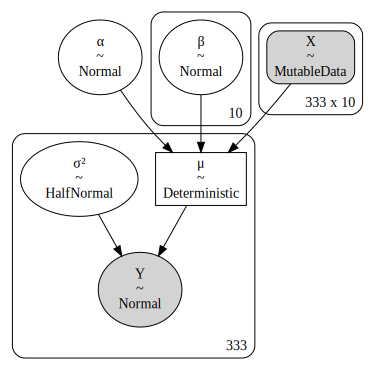

In [42]:

pm.model_to_graphviz(bayes_model)

In [43]:
import arviz as az

az.summary(trace_mlr, var_names=["β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],0.000,0.001,-0.001,0.002,0.000,0.000,412.0,953.0,1.01
β[1],0.000,0.001,-0.001,0.002,0.000,0.000,165.0,923.0,1.02
β[2],-0.955,95.061,-184.240,181.337,3.809,2.694,617.0,1445.0,1.02
β[3],0.000,0.000,-0.000,0.001,0.000,0.000,122.0,98.0,1.05
β[4],0.000,0.000,-0.000,0.001,0.000,0.000,221.0,427.0,1.07
β[5],0.071,0.065,-0.028,0.179,0.006,0.004,194.0,1159.0,1.03
β[6],0.000,0.004,-0.005,0.007,0.000,0.000,91.0,853.0,1.04
β[7],0.010,0.098,-0.136,0.213,0.008,0.006,65.0,188.0,1.05
β[8],-0.559,7.088,-12.162,10.243,1.052,0.749,25.0,43.0,1.10
β[9],0.051,0.129,-0.096,0.230,0.022,0.016,116.0,31.0,1.03


[Text(0, 0.22499999999999998, 'Goals conceded'),
 Text(0, 1.4999999999999998, 'Champions League_Goals'),
 Text(0, 2.775, 'Championship_Goals'),
 Text(0, 4.049999999999999, 'LaLiga_Goals'),
 Text(0, 5.325, 'Premier League_Goals'),
 Text(0, 6.600000000000001, 'Supercopa_Goals'),
 Text(0, 7.875000000000002, 'Champions League winner'),
 Text(0, 9.150000000000002, 'European champion'),
 Text(0, 10.425000000000002, 'Olympic medalist'),
 Text(0, 11.700000000000005, 'World Cup winner')]

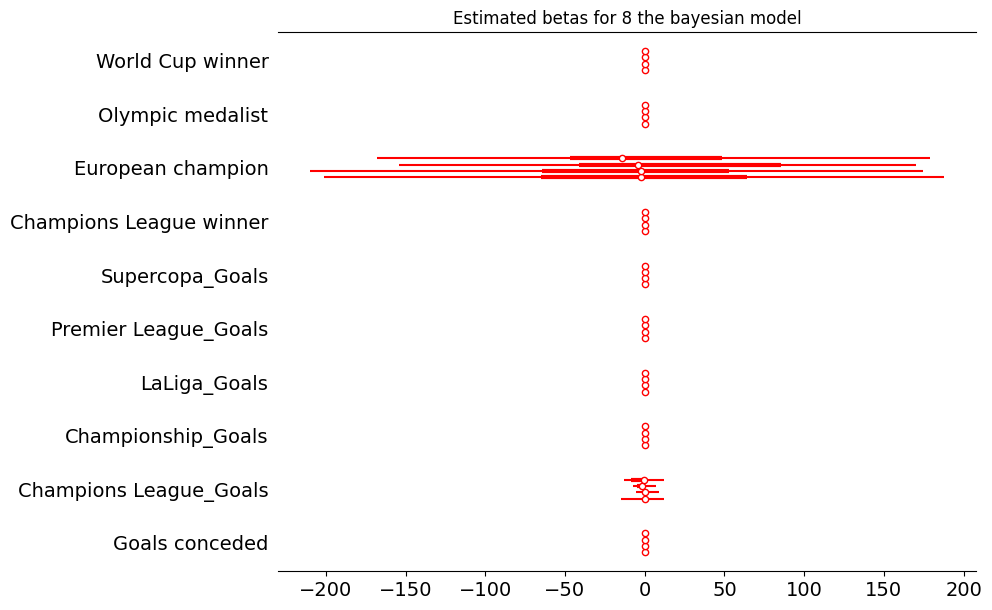

In [92]:
axes = az.plot_forest(trace_mlr,

                           var_names=["β"],
                           colors='red',

                           figsize=(9, 7))

axes[0].set_title('Estimated betas for 8 the bayesian model')
axes[0].set_yticklabels(X_train.columns)

Text(0.5, 1.0, 'Estimated betas for 8 the bayesian model')

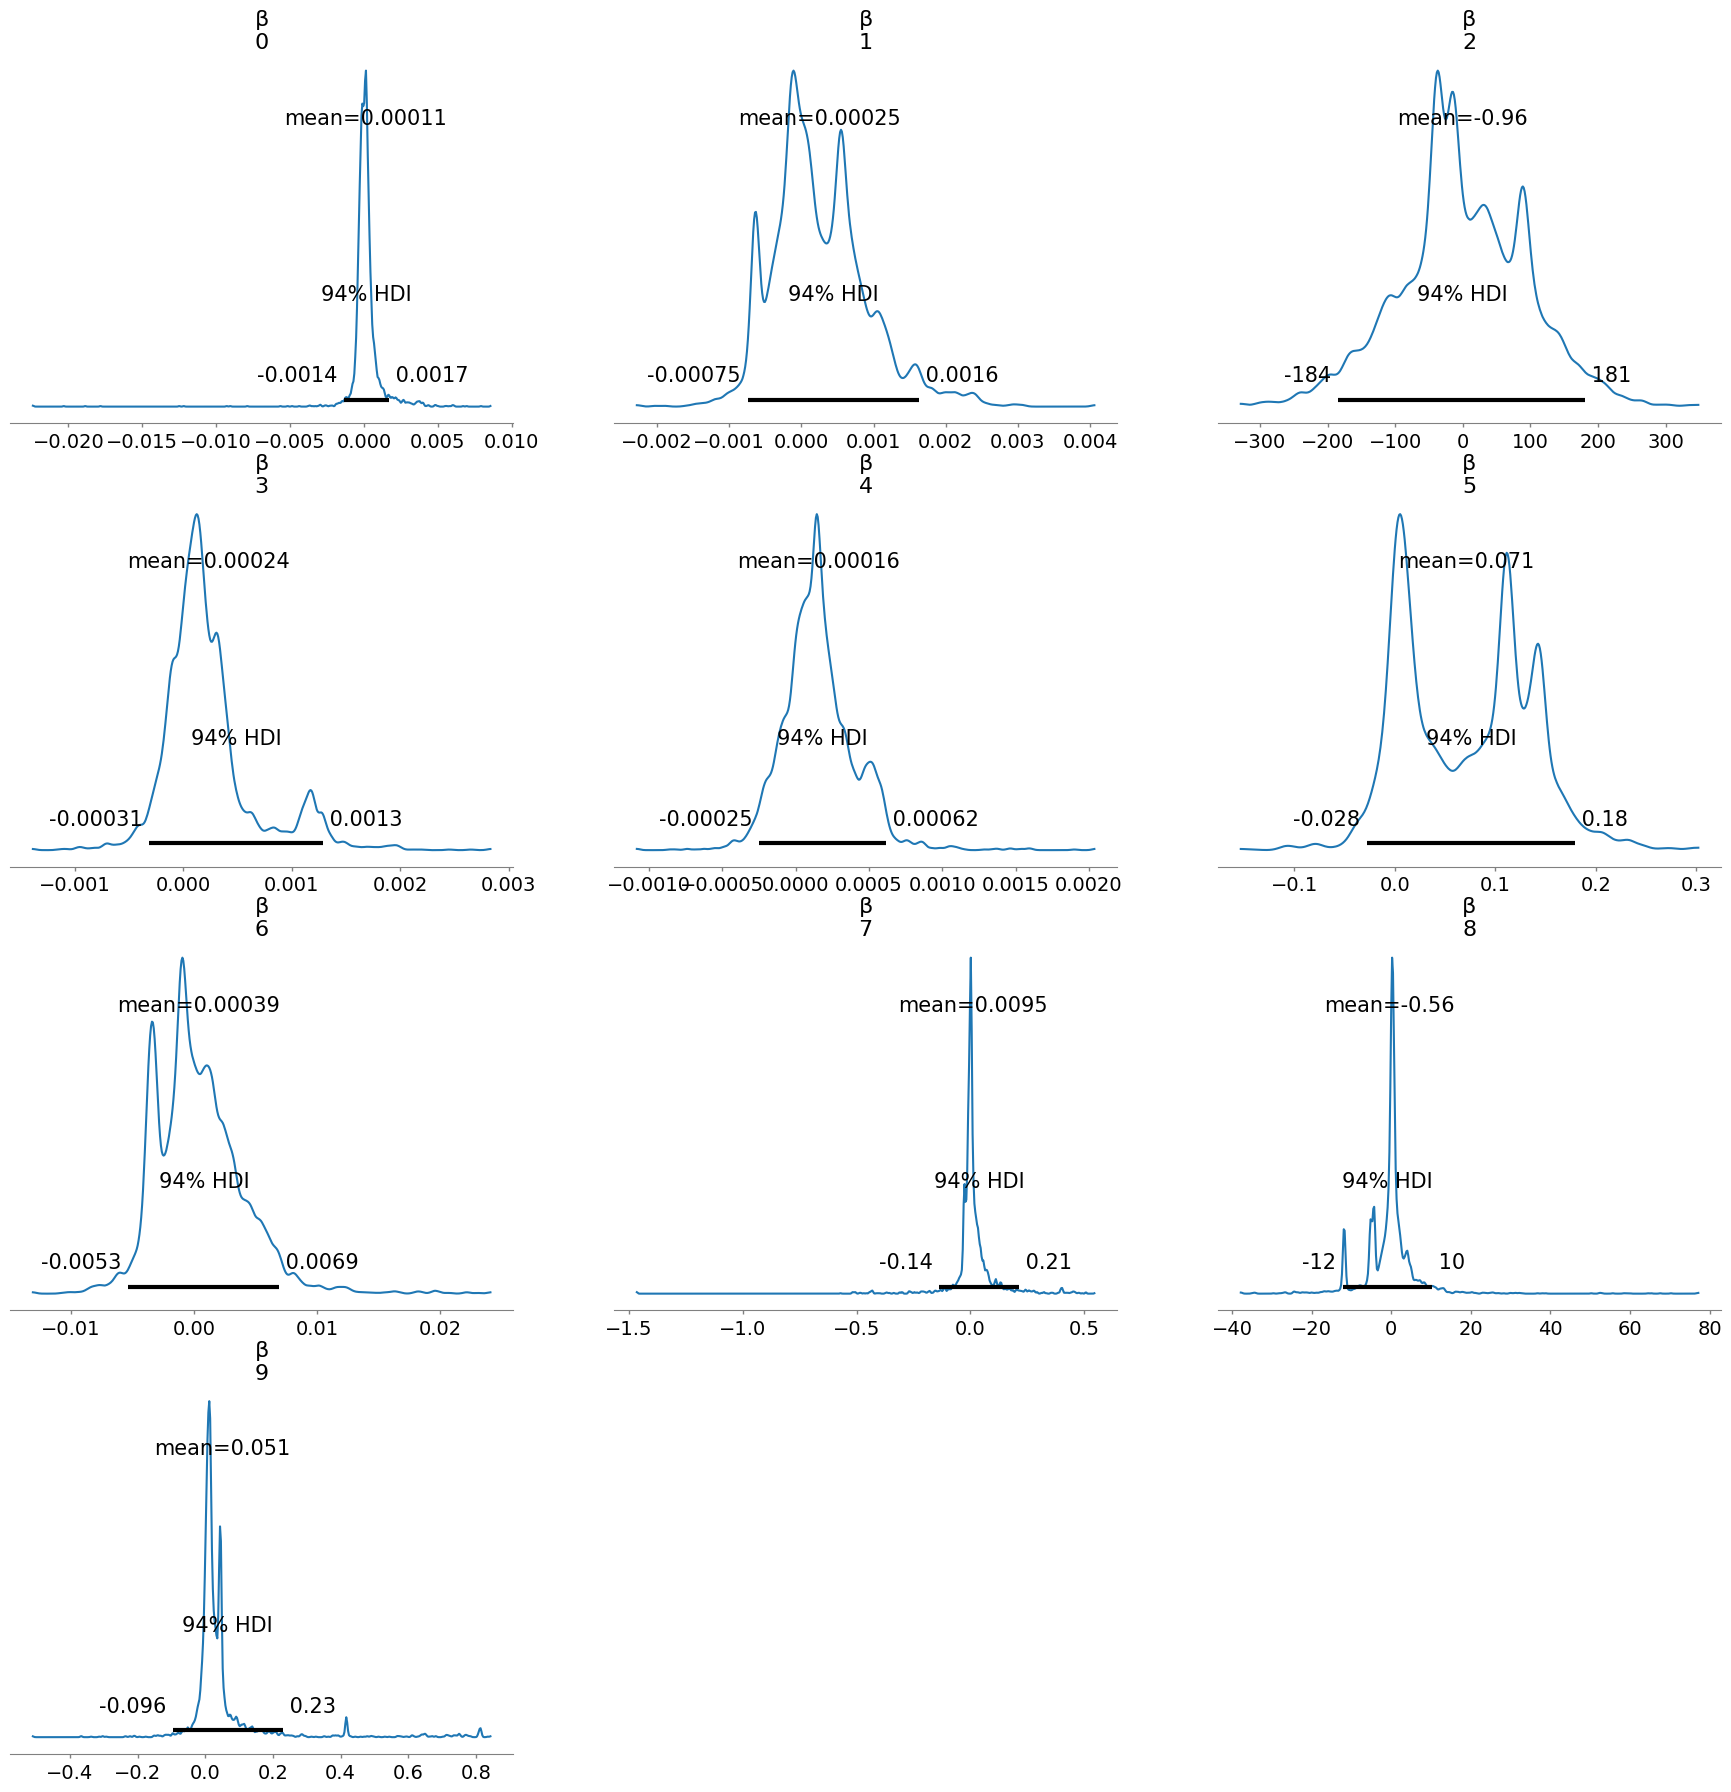

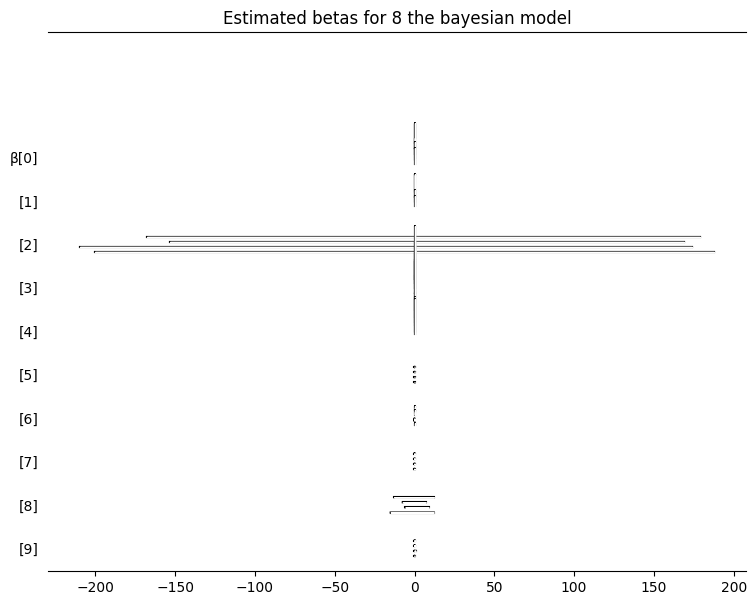

In [85]:
az.plot_posterior(trace_mlr, var_names=["β"])



In [68]:
with bayes_model:
    pm.set_data({"X": X_test})
    trace_mlr_pred = pm.sample_posterior_predictive(
        trace_mlr,
        var_names=["μ"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
    )

Sampling: []


TypeError: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups

/home/thejarmanitor/miniconda3/envs/outplayed/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (333) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'μ\n0'}>,
        <Axes: title={'center': 'μ\n1'}>,
        <Axes: title={'center': 'μ\n2'}>,
        <Axes: title={'center': 'μ\n3'}>],
       [<Axes: title={'center': 'μ\n4'}>,
        <Axes: title={'center': 'μ\n5'}>,
        <Axes: title={'center': 'μ\n6'}>,
        <Axes: title={'center': 'μ\n7'}>],
       [<Axes: title={'center': 'μ\n8'}>,
        <Axes: title={'center': 'μ\n9'}>,
        <Axes: title={'center': 'μ\n10'}>,
        <Axes: title={'center': 'μ\n11'}>],
       [<Axes: title={'center': 'μ\n12'}>,
        <Axes: title={'center': 'μ\n13'}>,
        <Axes: title={'center': 'μ\n14'}>,
        <Axes: title={'center': 'μ\n15'}>],
       [<Axes: title={'center': 'μ\n16'}>,
        <Axes: title={'center': 'μ\n17'}>,
        <Axes: title={'center': 'μ\n18'}>,
        <Axes: title={'center': 'μ\n19'}>],
       [<Axes: title={'center': 'μ\n20'}>,
        <Axes: title={'center': 'μ\n21'}>,
        <Axes: title={'center': 'μ\n22'}>,
        <Axes: t

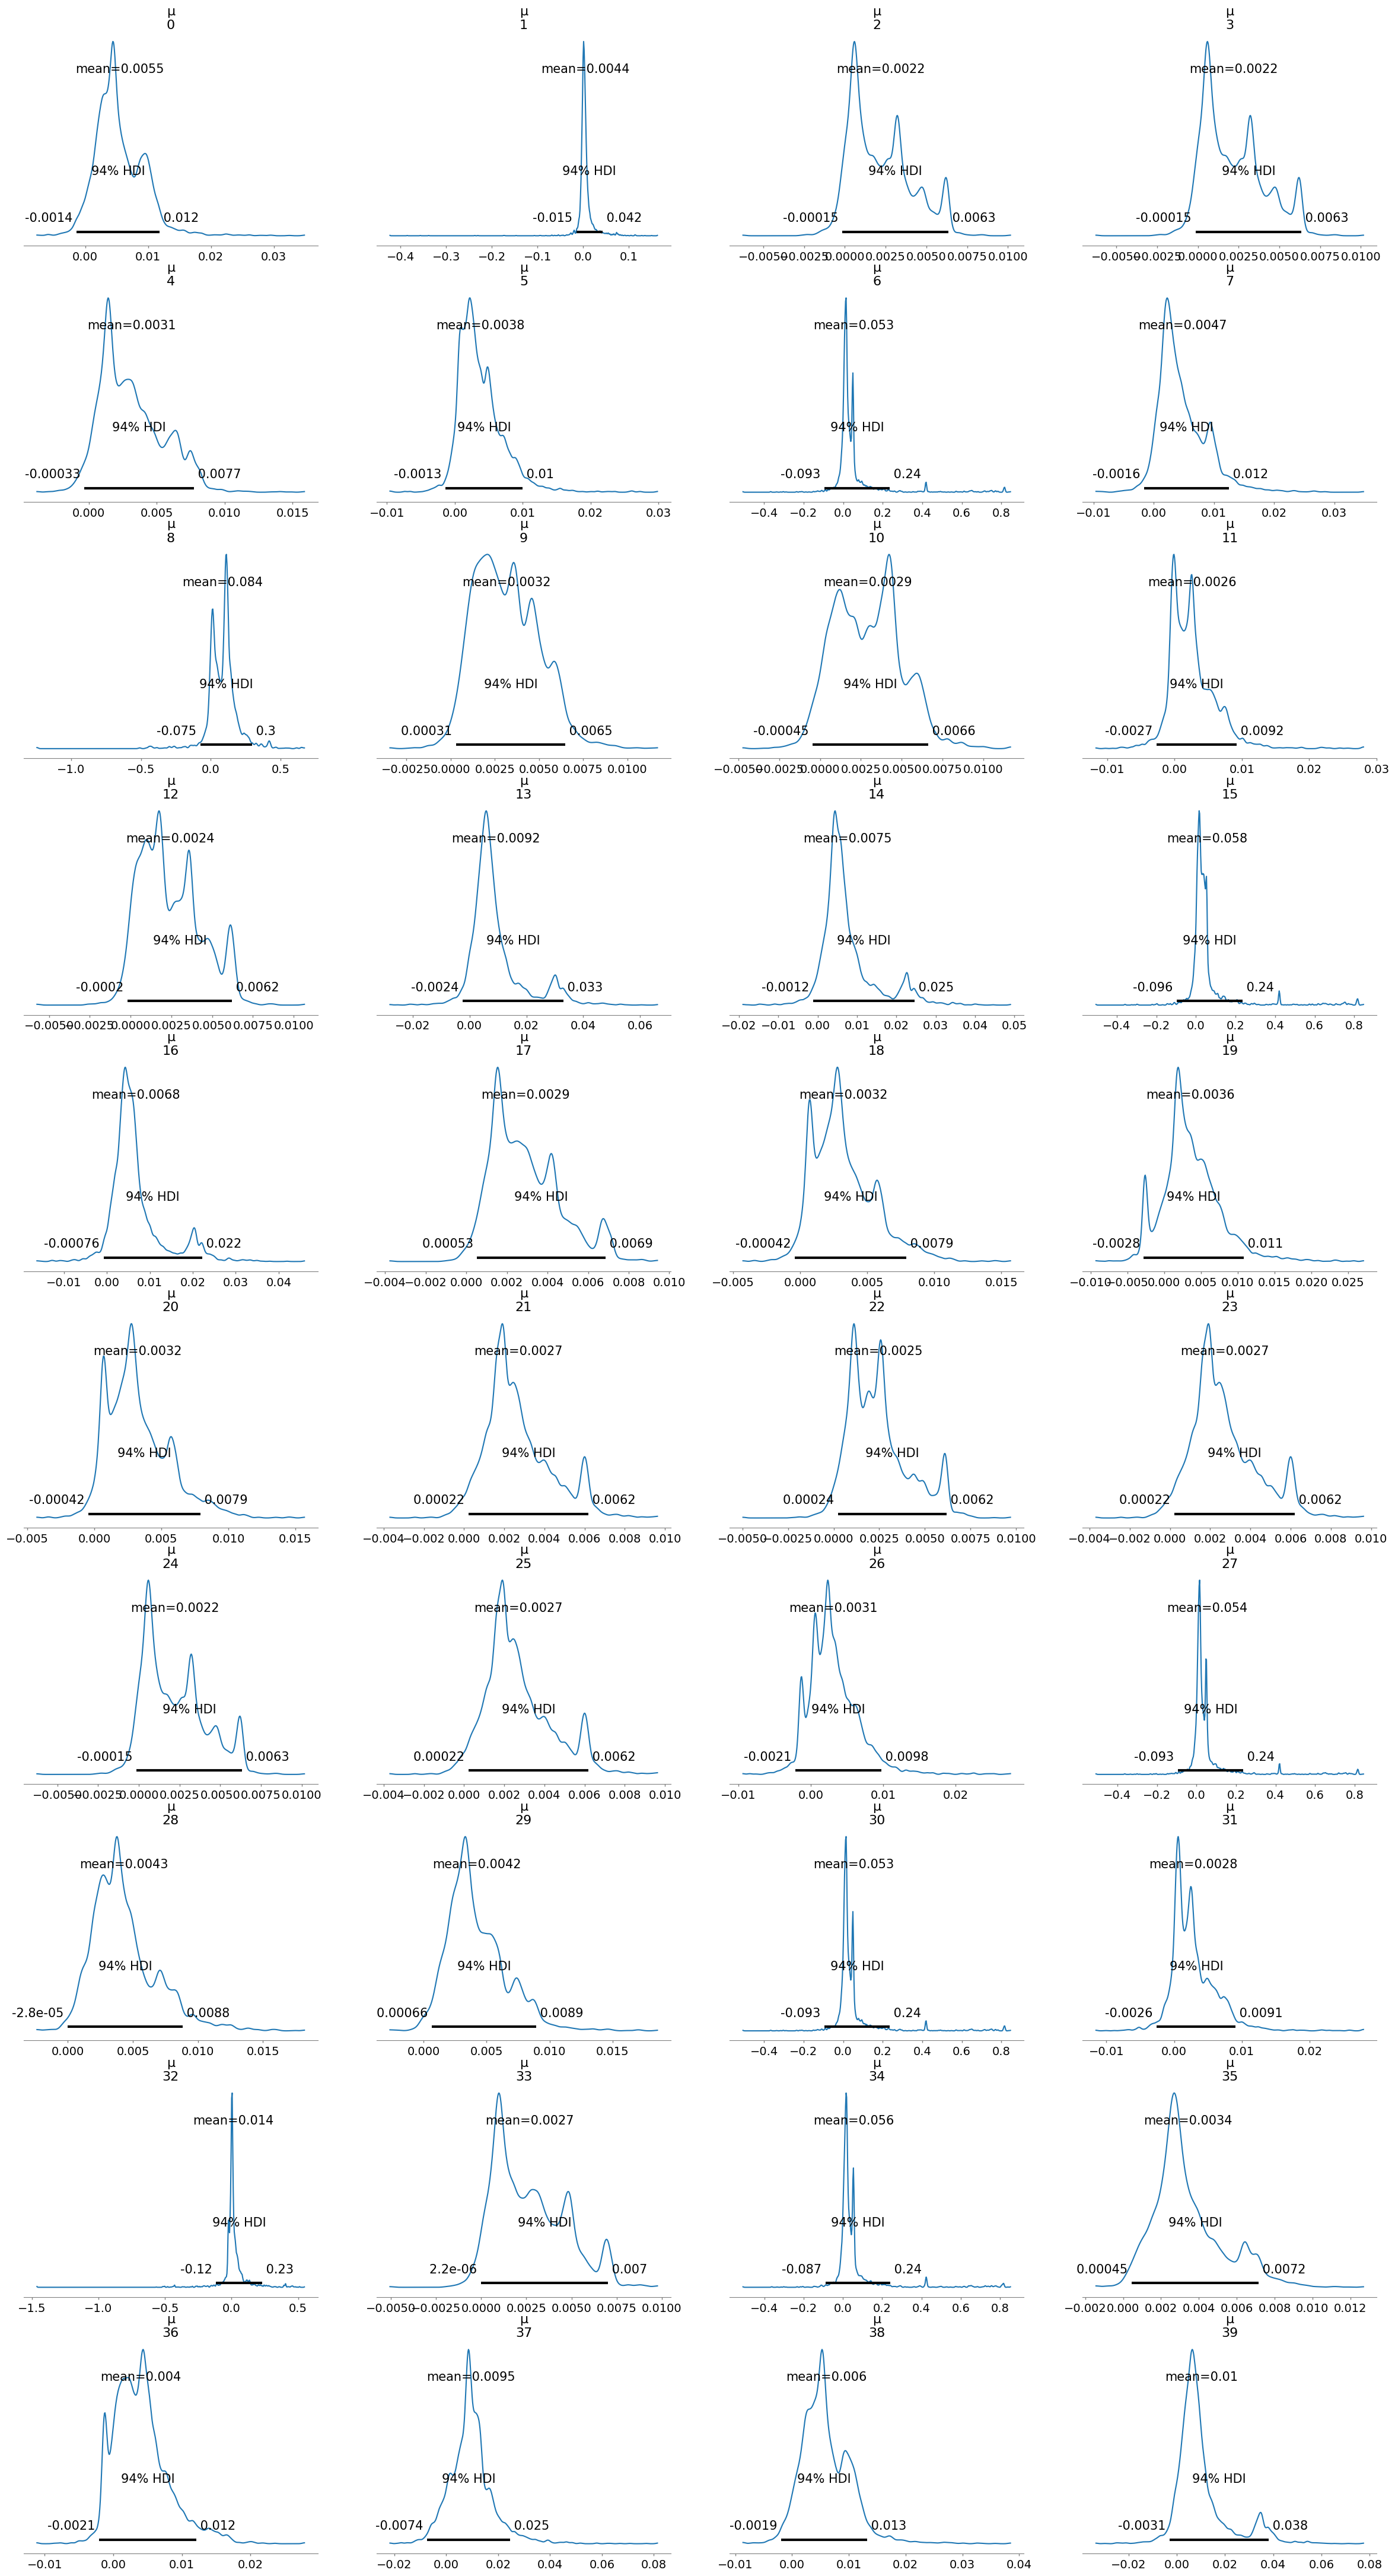

In [70]:
az.plot_pre(trace_mlr_pred, var_names=["μ"])

In [77]:
p_test_pred = trace_mlr_pred.predictions.data_vars["μ"].mean(dim=["chain", "draw"]).to_numpy()

p_test_pred


array([0.00345739, 0.0060267 , 0.00397289, 0.00439555, 0.01125165,
       0.00715222, 0.00220414, 0.00270855, 0.00321295, 0.00475553,
       0.14939347, 0.00419027, 0.00270855, 0.00220414, 0.00396956,
       0.00296075, 0.00422176, 0.00366064, 0.00455208, 0.00719582,
       0.00296075, 0.00270855, 0.15059777, 0.00340763, 0.00284236,
       0.00346516, 0.0063498 , 0.00414098, 0.0040946 ])

In [78]:
predictions = pd.DataFrame(y_test)
predictions.insert(1, "Pred_avg", p_test_pred)
predictions["Pred_avg"]

Player                 Year
André Onana            23.0    0.003457
Antoine Griezmann      23.0    0.006027
Bernardo Silva         23.0    0.003973
Bukayo Saka            23.0    0.004396
Erling Haaland         23.0    0.011252
Harry Kane             23.0    0.007152
Jamal Musiala          23.0    0.002204
Joško Gvardiol         23.0    0.002709
Jude Bellingham        23.0    0.003213
Julián Álvarez         23.0    0.004756
Karim Benzema          23.0    0.149393
Kevin De Bruyne        23.0    0.004190
Khvicha Kvaratskhelia  23.0    0.002709
Kim Min-jae            23.0    0.002204
Kylian Mbappé          23.0    0.003970
Lautaro Martínez       23.0    0.002961
Lionel Messi           23.0    0.004222
Luka Modrić            23.0    0.003661
Martin Ødegaard        23.0    0.004552
Mohamed Salah          23.0    0.007196
Nicolò Barella         23.0    0.002961
Randal Kolo Muani      23.0    0.002709
Robert Lewandowski     23.0    0.150598
Rodri                  23.0    0.003408
Rúben Dias  

In [83]:
predictions.sort_values(by="Pred_avg", ascending=False).iloc[:11,:]

,,Share,Pred_avg
Player,Year,,
Robert Lewandowski,23.0,0.0082,0.150598
Karim Benzema,23.0,0.0041,0.149393
Erling Haaland,23.0,0.2425,0.011252
Mohamed Salah,23.0,0.0088,0.007196
Harry Kane,23.0,0.0027,0.007152
Vinícius Júnior,23.0,0.0333,0.006350
Antoine Griezmann,23.0,0.0027,0.006027
Julián Álvarez,23.0,0.0190,0.004756
Martin Ødegaard,23.0,0.0000,0.004552
